In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

In [2]:
df = pd.read_parquet('../data/curated/adjusted_probabilities_2023')


In [3]:
df

,player_id,match_id,player_first_name,player_last_name,team_name,new_0,new_1,new_2,new_3,exp_votes
0,CD_I1000223,10007,Liam,Baker,Richmond,0.995547,0.002930,0.001302,0.000221,0.006197
1,CD_I1002245,10007,Noah,Balta,Richmond,0.998804,0.000867,0.000294,0.000035,0.001560
2,CD_I993993,10007,Shai,Bolton,Richmond,0.945568,0.029028,0.018752,0.006653,0.086490
3,CD_I295203,10007,Nathan,Broad,Richmond,0.995564,0.002881,0.001334,0.000221,0.006212
4,CD_I270896,10007,Trent,Cotchin,Richmond,0.992144,0.005094,0.002287,0.000474,0.011092
...,...,...,...,...,...,...,...,...,...,...
41,CD_I294305,10199,Lachie,Whitfield,GWS Giants,0.496011,0.138360,0.170193,0.195435,1.065053
42,CD_I1008139,10199,Toby,Bedford,GWS Giants,0.991501,0.005273,0.002587,0.000640,0.012366
43,CD_I290675,10199,Daniel,Lloyd,GWS Giants,0.988382,0.007227,0.003536,0.000854,0.016863
44,CD_I1008123,10199,Jake,Riccardi,GWS Giants,0.995192,0.003148,0.001401,0.000258,0.006724


In [4]:
players = list(df.player_id.unique())
match_ids = list(df.match_id.unique())

In [5]:
num_simulations = 10_000

votes_3 = []
votes_2 = []
votes_1 = []

# simulate 10,000 seasons 
for _ in tqdm(range(num_simulations), desc="Simulations"):
    
    # simulate every game in the season, choose a 3-2-1 vote
    for match in match_ids:
        sub_df = df.query('match_id == @match')
        match_players = sub_df.player_id.tolist()

        match_prob_3 = sub_df.new_3.tolist()
        match_prob_2 = sub_df.new_2.tolist()
        match_prob_1 = sub_df.new_1.tolist()

        vote_3 = np.random.choice(match_players, 1, p=match_prob_3)[0]
        vote_2 = vote_3  # Initialize with a value that requires re-selection
        while vote_2 == vote_3:
            vote_2 = np.random.choice(match_players, 1, p=match_prob_2)[0]

        vote_1 = vote_3  # Initialize with a value that requires re-selection
        while vote_1 == vote_3 or vote_1 == vote_2:
            vote_1 = np.random.choice(match_players, 1, p=match_prob_1)[0]

        votes_3.append(vote_3)
        votes_2.append(vote_2)
        votes_1.append(vote_1)


Simulations: 100%|████████████████████████| 10000/10000 [19:12<00:00,  8.68it/s]


In [6]:
player_votes = {}

In [7]:
for player in tqdm(players):
    
    votes = 3*votes_3.count(player) + 2*votes_2.count(player) + 1*votes_2.count(player)
    
    player_votes[player] = votes / num_simulations

100%|█████████████████████████████████████████| 663/663 [01:59<00:00,  5.54it/s]


In [8]:
votes_df = pd.DataFrame(player_votes.items(), columns=['player_id', 'predicted_votes'])

In [9]:
votes_df.sort_values('predicted_votes', ascending=False)[:10]

,player_id,predicted_votes
194,CD_I298210,27.0864
161,CD_I293535,24.3633
74,CD_I1023261,24.1221
153,CD_I1001299,21.6534
216,CD_I297373,21.5118
142,CD_I1006121,21.0282
364,CD_I992016,20.1990
261,CD_I1013128,20.0280
242,CD_I1009199,18.9972
396,CD_I1009420,18.8430


In [10]:
player_info = df[['player_id', 'player_first_name', 'player_last_name', 'team_name']].drop_duplicates('player_id')

In [11]:
full_df = pd.merge(player_info, votes_df, on='player_id', how='inner')

In [12]:
full_df.sort_values('predicted_votes', ascending=False, inplace=True)

In [13]:
full_df[:10]

,player_id,player_first_name,player_last_name,team_name,predicted_votes
194,CD_I298210,Christian,Petracca,Melbourne,27.0864
161,CD_I293535,Lachie,Neale,Brisbane Lions,24.3633
74,CD_I1023261,Nick,Daicos,Collingwood,24.1221
153,CD_I1001299,Connor,Rozee,Port Adelaide,21.6534
216,CD_I297373,Marcus,Bontempelli,Western Bulldogs,21.5118
142,CD_I1006121,Zak,Butters,Port Adelaide,21.0282
364,CD_I992016,Zach,Merrett,Essendon,20.1990
261,CD_I1013128,Errol,Gulden,Sydney Swans,20.0280
242,CD_I1009199,Noah,Anderson,Gold Coast Suns,18.9972
396,CD_I1009420,Caleb,Serong,Fremantle,18.8430


In [14]:
def present_name(row):
    
    name = f'{row["player_first_name"][0]}. {row["player_last_name"]}'
    
    return name

In [15]:
full_df['player'] = full_df.apply(present_name, axis=1)

In [16]:
final_df = full_df[['player', 'team_name', 'predicted_votes']]

In [17]:
final_df[:10]

,player,team_name,predicted_votes
194,C. Petracca,Melbourne,27.0864
161,L. Neale,Brisbane Lions,24.3633
74,N. Daicos,Collingwood,24.1221
153,C. Rozee,Port Adelaide,21.6534
216,M. Bontempelli,Western Bulldogs,21.5118
142,Z. Butters,Port Adelaide,21.0282
364,Z. Merrett,Essendon,20.1990
261,E. Gulden,Sydney Swans,20.0280
242,N. Anderson,Gold Coast Suns,18.9972
396,C. Serong,Fremantle,18.8430


In [18]:
final_df.to_parquet('../data/curated/final_leaderboard_2023')

In [19]:
top_5_players = final_df.player[:5]
top_5_votes = final_df.predicted_votes[:5]

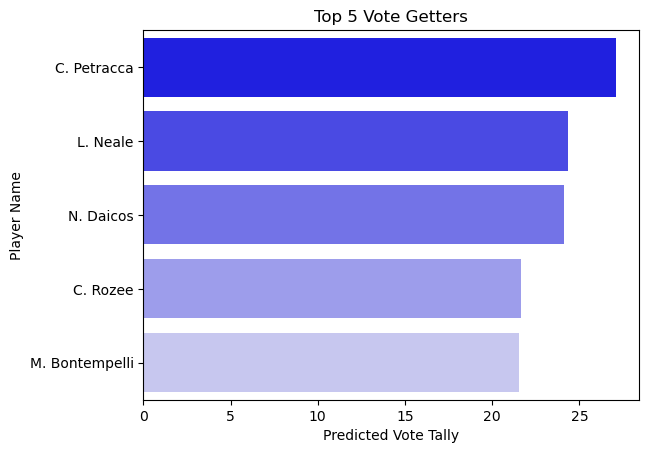

In [23]:
custom_palette = sns.light_palette("blue", reverse=True)


sns.barplot(y=top_5_players, x=top_5_votes, orient='h', palette=custom_palette)

plt.title('Top 5 Vote Getters')
plt.ylabel('Player Name')
plt.xlabel('Predicted Vote Tally')
#plt.save('../')
plt.show()

In [24]:
vote_breakdown = {}

for player in tqdm(players):
    
    vote_tally_3 = votes_3.count(player)  
    vote_tally_2 = votes_2.count(player)  
    vote_tally_1 = votes_1.count(player)

    vote_breakdown[player] = [vote_tally_3 / num_simulations, 
                              vote_tally_2 / num_simulations, 
                              vote_tally_1 / num_simulations]

100%|█████████████████████████████████████████| 663/663 [02:01<00:00,  5.44it/s]


In [25]:
vote_breakdown_df = pd.DataFrame(columns=['player_id', 'count_3', 'count_2', 'count_1'])

In [26]:
i=0

for idx in vote_breakdown:
    
    
    player_id = idx
    count_3 = vote_breakdown[player_id][0]
    count_2 = vote_breakdown[player_id][1]
    count_1 = vote_breakdown[player_id][2]
    
    row = {i: [player_id, count_3, count_2, count_1]}
    
    i += 1
    new_row = pd.DataFrame.from_dict(row, columns=['player_id', 'count_3', 'count_2', 'count_1'], orient='index')
    
    vote_breakdown_df = pd.concat([vote_breakdown_df, new_row])


In [27]:
vote_breakdown_df

,player_id,count_3,count_2,count_1
0,CD_I1000223,0.1580,0.5523,0.6159
1,CD_I1002245,0.0441,0.1546,0.2879
2,CD_I993993,2.3994,1.6383,1.1671
3,CD_I295203,0.0742,0.1701,0.2471
4,CD_I270896,0.3387,0.3259,0.2411
...,...,...,...,...
658,CD_I1023542,0.0000,0.0001,0.0002
659,CD_I294199,0.0017,0.0071,0.0136
660,CD_I1017063,0.0001,0.0001,0.0012
661,CD_I1031829,0.0000,0.0018,0.0061


In [28]:
vote_breakdown_df = pd.merge(vote_breakdown_df, full_df)

In [29]:
vote_breakdown_df.columns

Index(['player_id', 'count_3', 'count_2', 'count_1', 'player_first_name',
       'player_last_name', 'team_name', 'predicted_votes', 'player'],
      dtype='object')

In [30]:
reorder_cols = [
    'player', 'team_name', 'count_3', 'count_2', 'count_1', 'predicted_votes'
]

In [35]:
vote_breakdown_df[reorder_cols].sort_values('predicted_votes', ascending=False)[:10]

,player,team_name,count_3,count_2,count_1,predicted_votes
194,C. Petracca,Melbourne,5.5042,3.5246,2.1196,27.0864
161,L. Neale,Brisbane Lions,5.1818,2.9393,1.3800,24.3633
74,N. Daicos,Collingwood,5.2393,2.8014,1.3947,24.1221
153,C. Rozee,Port Adelaide,4.4724,2.7454,1.9781,21.6534
216,M. Bontempelli,Western Bulldogs,4.9061,2.2645,1.6064,21.5118
142,Z. Butters,Port Adelaide,4.5894,2.4200,1.5744,21.0282
364,Z. Merrett,Essendon,4.2139,2.5191,1.6338,20.1990
261,E. Gulden,Sydney Swans,4.4241,2.2519,1.5941,20.0280
242,N. Anderson,Gold Coast Suns,3.7437,2.5887,1.7481,18.9972
396,C. Serong,Fremantle,3.5942,2.6868,1.9204,18.8430
